# CNN WITH DATASET MINST

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

## DATA

### DISTRIBUTION DATA

In [ ]:
# Trực quan hóa và in ra phân bố các nhãn của tập dữ liệu
def analyze_distribution(y_data, title="Distribution of digits"):
    unique, counts = np.unique(np.argmax(y_data, axis=1), return_counts=True) # Tính toán các chữ số duy nhất và số lượng của chúng

    plt.figure(figsize=(10, 5))
    plt.bar(unique, counts) # Tạo biểu đồ cột
    plt.title(title)
    plt.xlabel('Digit')
    plt.ylabel('Count')
    plt.show()

    print("\nDigit distribution:")
    for digit, count in zip(unique, counts): # Lập qua từng chữ số và số lượng của nó
        print(f"Digit {digit}: {count} samples ({count/len(y_data)*100:.2f}%)")

### BALANCED DATA

In [ ]:
# Tạo dataset cân bằng giữa các nhãn
def load_balanced_subset(X_train, y_train, samples_per_class=100):
    """
    Lấy một tập con cân bằng từ dữ liệu training
    """
    num_classes = 10
    indices = [] # Lưu chỉ số của mẫu được chọn

    # Chuyển one-hot encoding về nhãn số
    y_labels = np.argmax(y_train, axis=1)

    # Lấy indices cho mỗi class
    for i in range(num_classes):
        class_indices = np.where(y_labels == i)[0] # Tìm chỉ số của tất cả các mẫu thuộc lớp i
        selected_indices = np.random.choice(class_indices, samples_per_class, replace=False) # Chọn ngẫu nhiên 100 chỉ số cho mẫu
        indices.extend(selected_indices)

    # Shuffle indices
    np.random.shuffle(indices) # Tránh thiên vị

    return X_train[indices], y_train[indices]

### PROCESSING DATA

In [ ]:
# Load và tiền xử lý dữ liệu
def load_mnist_data():
    # Load MNIST dataset
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Reshape và normalize dữ liệu về [0, 1]
    X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

    # Chuyển thành One-hot encoding labels
    encoder = OneHotEncoder(sparse_output=False) # sparse_output đảm bảo đầu ra là một mảng dày đặc
    y_train = encoder.fit_transform(y_train.reshape(-1, 1))
    y_test = encoder.transform(y_test.reshape(-1, 1))

    return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = load_mnist_data()

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
y_test shape: (10000, 10)


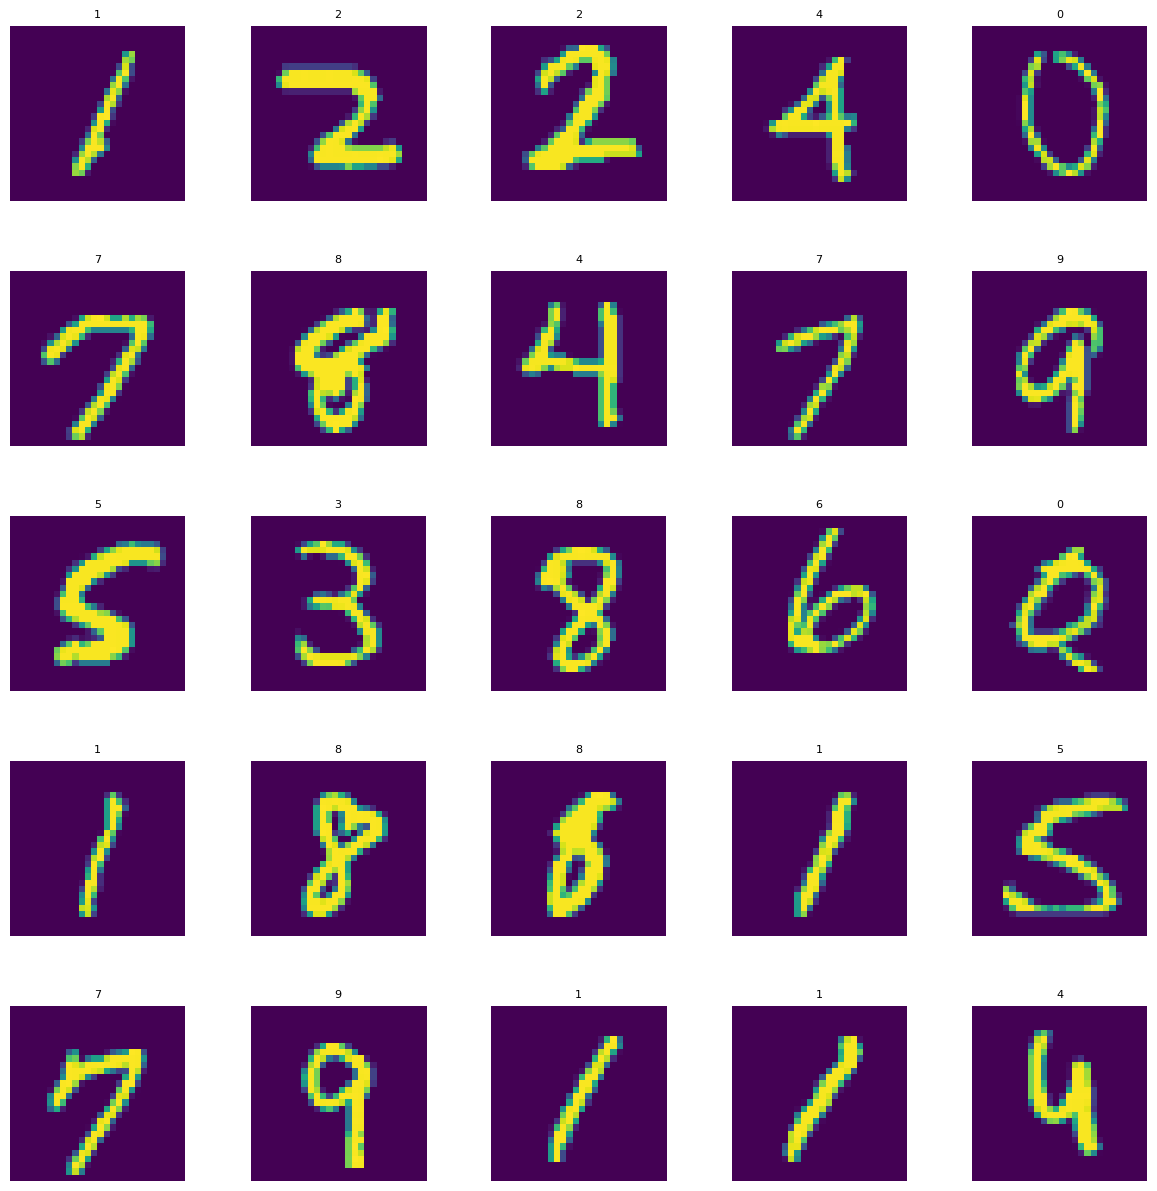

In [ ]:
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

grid = 5

fig, axs = plt.subplots(grid, grid, figsize=(15, 15)) # tạo lưới 5 * 5

for i in range(grid):
    for j in range(grid):
        index = np.random.randint(0, len(X_train)) # Chọn ảnh tại vị trí ngẫu nhiên
        axs[i, j].imshow(X_train[index])

        # Lấy ra nhãn thực tế
        label_index = np.argmax(y_train[index])

        axs[i, j].set_title(labels[label_index], fontsize = 8) # Label của ảnh
        axs[i, j].axis("off") # Không vẽ trung tung, hoành
plt.subplots_adjust(hspace=0.4) # Độ giản cách

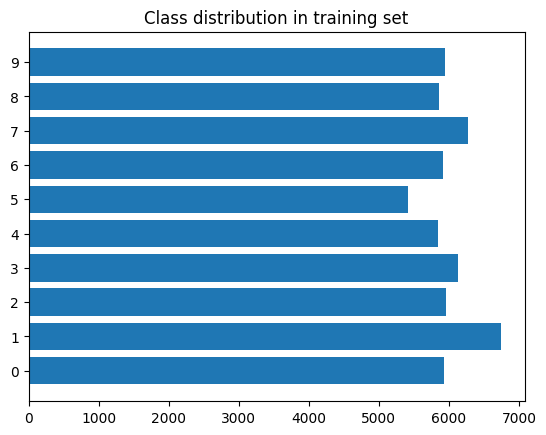

In [ ]:
classes_name = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

original_labels = np.argmax(y_train, axis=1)

# Tính toán tần suất xuất hiện của mỗi class
classes, counts = np.unique(original_labels, return_counts=True)

plt.barh(classes_name, counts)
plt.title("Class distribution in training set");

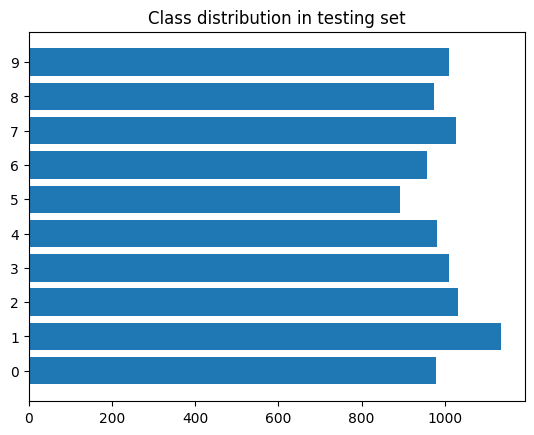

In [ ]:
original_labels = np.argmax(y_test, axis=1)

classes, counts = np.unique(original_labels, return_counts = True)
plt.barh(classes_name, counts)
plt.title("Class distribution in testing set");

## MODEL

### CONVOLUTION LAYER

In [ ]:
class Conv2D:
    def __init__(self, num_filters, kernel_size, input_shape, padding=0, stride=1):
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.input_shape = input_shape
        self.padding = padding
        self.stride = stride

        # He initialization
        input_channels = input_shape[-1] # lấy số lượng kênh của ảnh
        self.kernels = np.random.randn(num_filters, kernel_size, kernel_size, input_channels) * \
                      np.sqrt(2.0/(kernel_size * kernel_size * input_channels)) # Sử dụng phân phối chuẩn và kĩ thuật He initialization
        self.biases = np.zeros(num_filters)

    def forward(self, input):
        self.input = np.pad(input,
                           ((0, 0),
                            (self.padding, self.padding),
                            (self.padding, self.padding),
                            (0, 0)), 'constant')

        # Tính toán kích thước đầu ra
        batch_size = input.shape[0]
        output_height = int((self.input.shape[1] - self.kernel_size) / self.stride + 1)
        output_width = int((self.input.shape[2] - self.kernel_size) / self.stride + 1)

        # Khởi tạo ma trận đầu ra
        self.output = np.zeros((batch_size, output_height, output_width, self.num_filters))

        # Tính toán tích chập
        for b in range(batch_size):
            for i in range(0, output_height, self.stride):
                for j in range(0, output_width, self.stride):
                    input_slice = self.input[b, i:i+self.kernel_size, j:j+self.kernel_size, :] # Lấy vùng dữ liệu mà kernel sẽ chập
                    for k in range(self.num_filters):
                        self.output[b, i, j, k] = np.sum(input_slice * self.kernels[k]) + self.biases[k] # Tính toán tích chập

        return self.output

    def backward(self, grad_output, learning_rate=0.01):
        batch_size = grad_output.shape[0]
        grad_kernels = np.zeros_like(self.kernels) # tạo ma trận gradient cho kernel
        grad_input = np.zeros_like(self.input) # tạo ma trận gradient cho đầu vào của lớp tích chập

        # Tính toán gradient của kernel và input
        for b in range(batch_size):
            for i in range(0, grad_output.shape[1], self.stride):
                for j in range(0, grad_output.shape[2], self.stride):
                    input_slice = self.input[b, i:i+self.kernel_size, j:j+self.kernel_size, :]
                    for k in range(self.num_filters):
                        grad_kernels[k] += input_slice * grad_output[b, i, j, k]
                        grad_input[b, i:i+self.kernel_size, j:j+self.kernel_size, :] += self.kernels[k] * grad_output[b, i, j, k]

        # Cập nhật kernel và bias
        self.kernels -= learning_rate * grad_kernels / batch_size
        self.biases -= learning_rate * np.sum(grad_output, axis=(0,1,2)) / batch_size

        if self.padding > 0:
            grad_input = grad_input[:, self.padding:-self.padding, self.padding:-self.padding, :] # Loại bỏ padding nếu có
        return grad_input

### RELU ACTIVATION

In [ ]:
class ReLU:
    def forward(self, input):
        self.input = input
        return np.maximum(0, input)

    def backward(self, grad_output):
        return grad_output * (self.input > 0) # Chỉ truyền gradient cho các giá trị đầu vào là dương, còn lại sẽ thành 0


### MAXPOOLING LAYER

In [ ]:
# Giảm kích thước dữ liệu và trích xuất đặc trưng quan trọng
class MaxPool2D:
    def __init__(self, pool_size=2, stride=2):
        self.pool_size = pool_size
        self.stride = stride

    def forward(self, input):
        self.input = input
        self.batch_size, self.height, self.width, self.channels = input.shape

        output_height = int((self.height - self.pool_size) / self.stride + 1)
        output_width = int((self.width - self.pool_size) / self.stride + 1)

        output = np.zeros((self.batch_size, output_height, output_width, self.channels))
        self.max_indices = {} #từ điển để lưu chỉ số của các phần tử lớn nhất trong mỗi cửa sổ pooling -> backwark.

        for b in range(self.batch_size):
            for h in range(output_height):
                for w in range(output_width):
                    h_start = h * self.stride
                    h_end = h_start + self.pool_size
                    w_start = w * self.stride
                    w_end = w_start + self.pool_size

                    for c in range(self.channels):
                        pool_region = input[b, h_start:h_end, w_start:w_end, c]
                        output[b, h, w, c] = np.max(pool_region)

                        # Lưu vị trí phần tử lớn nhất trong pool_region:
                        '''
                          np.armax -> tìm chỉ số(số nguyên) của phần tử lớn nhất trong pool_region(đã được làm phẳng).
                          np.unravel_index -> chuyển đổi chữ số phảng thành chỉ số đa chiều (tương ứng với pool_region.shape).
                        '''
                        max_idx = np.unravel_index(np.argmax(pool_region), pool_region.shape)
                        self.max_indices[(b,h,w,c)] = (h_start + max_idx[0], w_start + max_idx[1])

        return output

    # Gradient chỉ được lan truyền ngược qua các neuron (pixel) có giá trị lớn nhất trong mỗi cửa sổ pooling, còn các neuron khác nhận gradient bằng 0
    def backward(self, grad_output):
        grad_input = np.zeros_like(self.input)

        for b in range(self.batch_size):
            for h in range(grad_output.shape[1]):
                for w in range(grad_output.shape[2]):
                    for c in range(self.channels):
                        h_max, w_max = self.max_indices[(b,h,w,c)]
                        grad_input[b, h_max, w_max, c] = grad_output[b, h, w, c] # gán tại vị trí lớn nhất giá trị gradient tương ứng.

        return grad_input

### FLATTEN

In [ ]:
# Duỗi ma trận thành vector để làm đầu vào cho dense
class Flatten:
    def forward(self, input):
        self.input_shape = input.shape
        return input.reshape(input.shape[0], -1)

    def backward(self, grad_output):
        return grad_output.reshape(self.input_shape)

### DENSE

In [ ]:
class Dense:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2.0/input_size)
        self.biases = np.zeros(output_size)

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.biases

    def backward(self, grad_output, learning_rate=0.01):
        grad_input = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(self.input.T, grad_output)
        grad_biases = np.sum(grad_output, axis=0) # Tính tổng grad_out theo chiều(dọc) của các mẫu dữ liệu

        self.weights -= learning_rate * grad_weights
        self.biases -= learning_rate * grad_biases

        return grad_input

### SOFTMAX + CROSS ENTROPY LOSS

In [ ]:
class SoftmaxCrossEntropyLoss:
    def forward(self, x, targets):
        shifted_logits = x - np.max(x, axis=1, keepdims=True) # Tránh tràn số
        exp_scores = np.exp(shifted_logits)
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        self.targets = targets

        N = x.shape[0]
        loss = -np.sum(targets * np.log(self.probs + 1e-8)) / N
        return loss

    def backward(self):
        N = self.targets.shape[0]
        return (self.probs - self.targets) / N

### BUILDING MODEL

In [ ]:
class MNISTClassifier:
    def __init__(self):
        # Architecture cho MNIST (28x28x1 input)
        self.conv1 = Conv2D(32, 3, (28, 28, 1), padding=1)  # 28x28x32
        self.relu1 = ReLU()
        self.pool1 = MaxPool2D()  # 14x14x32
        self.conv2 = Conv2D(64, 3, (14, 14, 32), padding=1)  # 14x14x64
        self.relu2 = ReLU()
        self.pool2 = MaxPool2D()  # 7x7x64
        flatten_size = flatten_size = np.prod(self.pool2.output_shape[1:]) # Tính kích thước ảnh sau khi làm phẳng
        self.flatten = Flatten()
        self.fc1 = Dense(flatten_size, 128)
        self.relu3 = ReLU()
        self.fc2 = Dense(128, 10)

    def forward(self, x):
        x = self.conv1.forward(x)
        x = self.relu1.forward(x)
        x = self.pool1.forward(x)
        x = self.conv2.forward(x)
        x = self.relu2.forward(x)
        x = self.pool2.forward(x)
        x = self.flatten.forward(x)
        x = self.fc1.forward(x)
        x = self.relu3.forward(x)
        x = self.fc2.forward(x)
        return x

    def backward(self, grad_output, learning_rate=0.01):
        grad = self.fc2.backward(grad_output, learning_rate)
        grad = self.relu3.backward(grad)
        grad = self.fc1.backward(grad, learning_rate)
        grad = self.flatten.backward(grad)
        grad = self.pool2.backward(grad)
        grad = self.relu2.backward(grad)
        grad = self.conv2.backward(grad, learning_rate)
        grad = self.pool1.backward(grad)
        grad = self.relu1.backward(grad)
        grad = self.conv1.backward(grad, learning_rate)

### TRAIN

In [ ]:
def train(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=32, learning_rate=0.01):
    loss_fn = SoftmaxCrossEntropyLoss()
    losses = []
    accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        # Shuffle the training data
        indices = np.random.permutation(len(X_train))
        X_train = X_train[indices]
        y_train = y_train[indices]

        for i in range(0, len(X_train), batch_size):
            batch_x = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]

            # Forward pass
            logits = model.forward(batch_x)
            loss = loss_fn.forward(logits, batch_y)
            total_loss += loss

            # Backward pass
            grad = loss_fn.backward()
            model.backward(grad, learning_rate)

        # Tính loss và accuracy cuối mỗi epoch
        avg_loss = total_loss / (len(X_train) / batch_size)
        accuracy = evaluate(model, X_val, y_val)

        losses.append(avg_loss)
        accuracies.append(accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Loss_train: {avg_loss:.4f}, Accuracy_val: {accuracy:.4f}')

    return losses, accuracies

### EVALUTION

In [ ]:
def evaluate(model, X_test, y_test):
    logits = model.forward(X_test)
    probs = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
    predictions = np.argmax(probs, axis=1)
    true_labels = np.argmax(y_test, axis=1)
    accuracy = np.mean(predictions == true_labels)
    return accuracy

### MAIN

#### PREPARING DATA


Phân bố dữ liệu sau khi cân bằng:


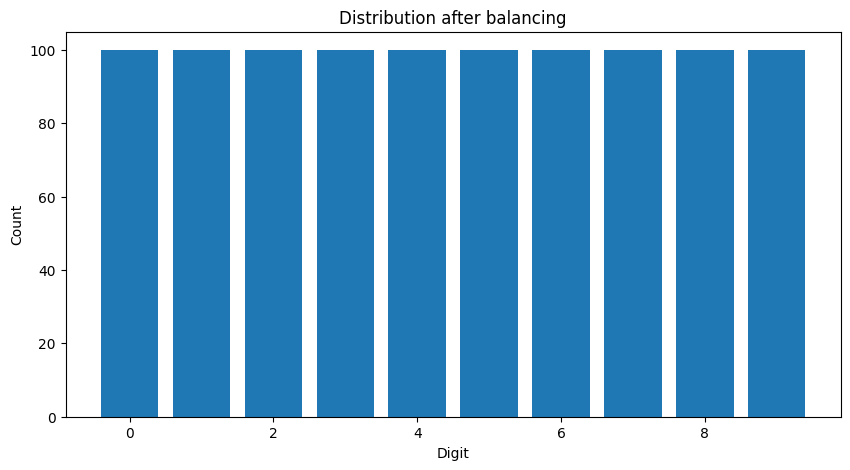


Digit distribution:
Digit 0: 100 samples (10.00%)
Digit 1: 100 samples (10.00%)
Digit 2: 100 samples (10.00%)
Digit 3: 100 samples (10.00%)
Digit 4: 100 samples (10.00%)
Digit 5: 100 samples (10.00%)
Digit 6: 100 samples (10.00%)
Digit 7: 100 samples (10.00%)
Digit 8: 100 samples (10.00%)
Digit 9: 100 samples (10.00%)


In [ ]:
X_train, y_train, X_test, y_test = load_mnist_data()

# Balance data và chia tập training thành training và validation
X_train_subset, y_train_subset = load_balanced_subset(X_train, y_train, 100)
X_train, X_val, y_train, y_val = train_test_split(X_train_subset, y_train_subset, test_size=0.2, random_state=42)

print("\nPhân bố dữ liệu sau khi cân bằng:")
analyze_distribution(y_train_subset, "Distribution after balancing")

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print( f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (800, 28, 28, 1)
y_train shape: (800, 10)
X_val shape: (200, 28, 28, 1)
y_val shape: (200, 10)


Epoch 1/10, Loss_train: 1.4863, Accuracy_val: 0.7400
Epoch 2/10, Loss_train: 0.7189, Accuracy_val: 0.8600
Epoch 3/10, Loss_train: 0.4767, Accuracy_val: 0.8800
Epoch 4/10, Loss_train: 0.3908, Accuracy_val: 0.8500
Epoch 5/10, Loss_train: 0.3272, Accuracy_val: 0.8800
Epoch 6/10, Loss_train: 0.2704, Accuracy_val: 0.8600
Epoch 7/10, Loss_train: 0.2374, Accuracy_val: 0.9000
Epoch 8/10, Loss_train: 0.2148, Accuracy_val: 0.9000
Epoch 9/10, Loss_train: 0.1833, Accuracy_val: 0.9000
Epoch 10/10, Loss_train: 0.1693, Accuracy_val: 0.9100
Test Accuracy: 0.9200


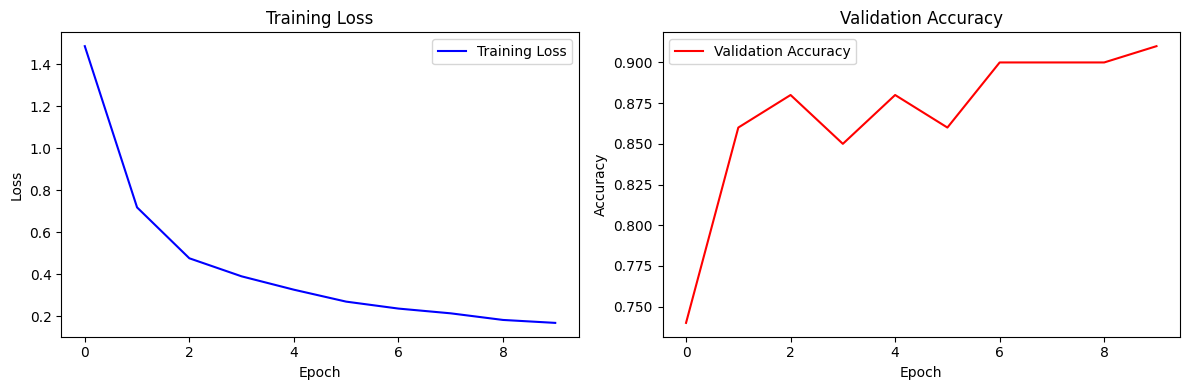

In [ ]:
if __name__ == "__main__":

    # Create and train model
    model = MNISTClassifier()

    # Train model
    losses, accuracies = train(model, X_train, y_train,
                              X_val, y_val, epochs=10, batch_size=16, learning_rate=0.01)

    # Evaluate trên tập test
    test_accuracy = evaluate(model, X_test[:100], y_test[:100])
    print(f'Test Accuracy: {test_accuracy:.4f}')

    # Plot training curves
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(losses, 'b-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, 'r-', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()